# 07. Elastic Net Model

**Mô hình:** Elastic Net (L1 + L2 regularization)

**Thư viện:** sklearn.linear_model.ElasticNet

**Metrics:** RMSFE, MAPE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Cấu hình hiển thị
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore") # Tắt cảnh báo hội tụ nếu có

# Hàm tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true == 0] = 1e-10 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Đã import thư viện.")

Đã import thư viện.


In [2]:
# Đọc dữ liệu
df_train = pd.read_csv('../data/processed/train_clean.csv')
df_test = pd.read_csv('../data/processed/test_clean.csv')

# Sửa lỗi encoding tên cột
df_train.columns = [c.replace('垄', '¢') for c in df_train.columns]
df_test.columns = [c.replace('垄', '¢') for c in df_test.columns]

# Đặt index thời gian
df_train['Fecha'] = pd.to_datetime(df_train['Fecha'])
df_test['Fecha'] = pd.to_datetime(df_test['Fecha'])
df_train = df_train.set_index('Fecha')
df_test = df_test.set_index('Fecha')

# Giữ lại các cột chung
common_cols = list(set(df_train.columns) & set(df_test.columns))
df_train = df_train[common_cols]
df_test = df_test[common_cols]

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (112, 190)
Test shape: (28, 190)


In [3]:
# Định nghĩa biến mục tiêu
TARGET_COL = 'Core CPI'

# Tách biến độc lập (X) và biến mục tiêu (y)
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]
X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

# Khởi tạo và huấn luyện mô hình ElasticNetCV
# l1_ratio: Danh sách các tỷ lệ L1/L2 để thử (từ gần giống Ridge đến gần giống Lasso)
# cv=5: Cross-validation 5-fold
model = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=None, # Tự động chọn dải alpha
    cv=5,
    random_state=42,
    max_iter=10000 # Tăng số vòng lặp để đảm bảo hội tụ
)

model.fit(X_train, y_train)

print(f"Đã huấn luyện xong Elastic Net.")
print(f"Best Alpha: {model.alpha_}")
print(f"Best L1 Ratio: {model.l1_ratio_}")
print(f"Số lượng biến được giữ lại (Hệ số != 0): {np.sum(model.coef_ != 0)} / {X_train.shape[1]}")

Đã huấn luyện xong Elastic Net.
Best Alpha: 0.0063199971946433725
Best L1 Ratio: 0.7
Số lượng biến được giữ lại (Hệ số != 0): 8 / 189


In [4]:
# Dự báo
y_pred = model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Tính Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

# Hiển thị kết quả
df_results = pd.DataFrame({
    'Metric': ['R2 Score', 'RMSE', 'MAE', 'MAPE (%)'],
    'Value': [r2, rmse, mae, mape]
})

print(f"\nKết quả dự báo Elastic Net cho '{TARGET_COL}':")
display(df_results)


Kết quả dự báo Elastic Net cho 'Core CPI':


,Metric,Value
0,R2 Score,0.102878
1,RMSE,0.111249
2,MAE,0.092773
3,MAPE (%),15.799512


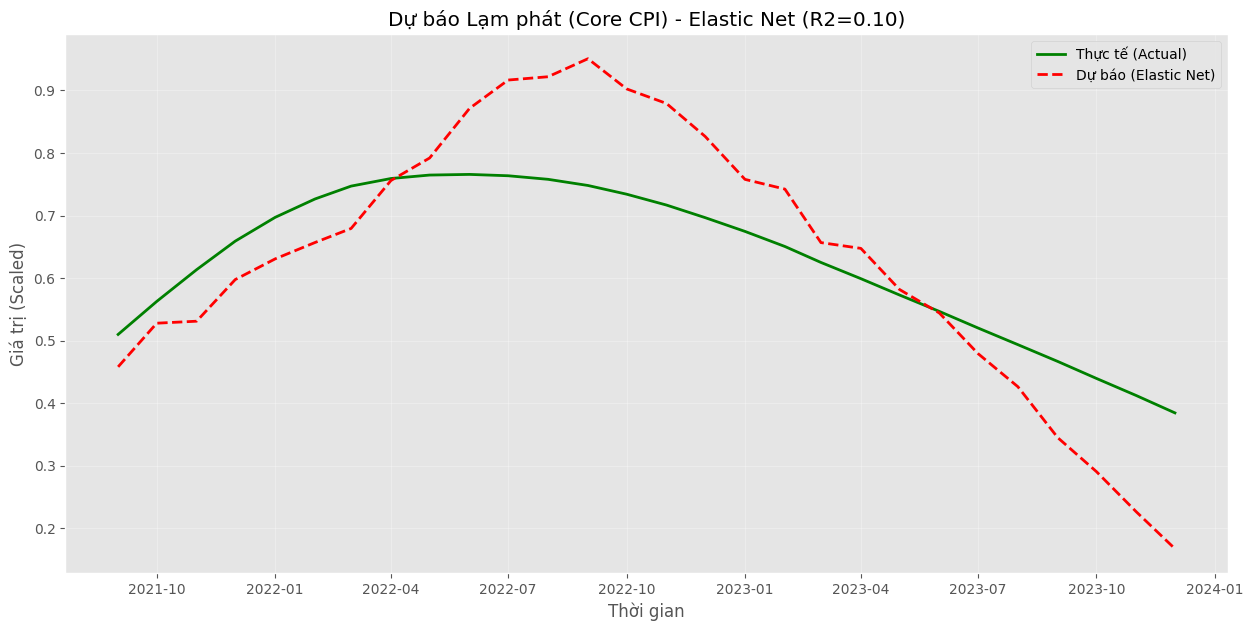

Đã lưu kết quả vào: ../results/tables\elasticnet_model_summary.csv
Đã lưu biểu đồ vào: ../results/figures\elasticnet_forecast_plot.png


In [5]:
# Tạo thư mục lưu trữ
OUTPUT_DIR_FIGURE = '../results/figures'
OUTPUT_DIR_TABLE = '../results/tables'
os.makedirs(OUTPUT_DIR_FIGURE, exist_ok=True)
os.makedirs(OUTPUT_DIR_TABLE, exist_ok=True)

# Lưu metrics
table_filename = os.path.join(OUTPUT_DIR_TABLE, 'elasticnet_model_summary.csv')
df_results.to_csv(table_filename, index=False)

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test.values, label='Thực tế (Actual)', color='green', linewidth=2)
plt.plot(y_pred_series.index, y_pred_series.values, label='Dự báo (Elastic Net)', color='red', linestyle='--', linewidth=2)
plt.title(f'Dự báo Lạm phát ({TARGET_COL}) - Elastic Net (R2={r2:.2f})')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị (Scaled)')
plt.legend()
plt.grid(True, alpha=0.3)

# Lưu biểu đồ
figure_filename = os.path.join(OUTPUT_DIR_FIGURE, 'elasticnet_forecast_plot.png')
plt.savefig(figure_filename, bbox_inches='tight', dpi=300)
plt.show()

print(f"Đã lưu kết quả vào: {table_filename}")
print(f"Đã lưu biểu đồ vào: {figure_filename}")